# *svoboda lab / tactile navigation*

## Setup evnironment

In [1]:
import os
import numpy as np
import pandas as pd
import json

## Setup plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')
from helper.plots import *
savefig = False

## Helper functions for loading and processing data

This helper function is using during loading to align tables to a primary key

In [3]:
def align(table, primary, index):
    table['sourceId'] = primary['sourceId']
    table.set_index(index,inplace = True)
    table.columns = table.columns.astype('float')
    return table

This helper function loads mutliple tables from a session into a dictionary where the keys are table names

In [4]:
def load(session, tables):
    # load the info
    with open(os.path.join(path,'data',session,'info.json')) as infile:
        info = json.load(infile)
        
    # load the units (which have our primary keys)
    units = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','units.csv'))
    
    # load all the tables
    d = {n : pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','%s.csv' % n)) for n in tables}
    
    # align the tables (specify each manually because different tables use different keys)
    d['waveforms'] = align(d['waveforms'], units, 'sourceId')
    d['profile'] = align(d['profile'], units, 'sourceId')
    xs, ys = smoothfit(d['profile'].columns.values, d['profile'].values[0],smooth=smooth, res=1000)
    smoothed = [smoothfit(d['profile'].columns.values, y, smooth=smooth,res=1000)[1] for y in d['profile'].values]
    d['profile'] = pd.DataFrame(smoothed, index=d['profile'].index, columns=xs)

    d['tuning'] = align(d['tuning'], units, ['sourceId', 'label'])
    d['tuningNum'] = d['tuning'].xs('numTrials', level='label')
    err = d['tuning'].xs('stdRate', level='label').divide(d['tuningNum'].apply(np.sqrt))
    d['tuning'] = d['tuning'].xs('meanRate', level='label')
    d['tuningErr'] = err
    d['tuningSummary'] = summarizeTuning(d['tuning'])
    d['ISI'] = align(d['ISI'], units, 'sourceId')
    d['profileSummary'] = summarizeProfile(d['profile'])
    
    if info['clAnm']:
        d['tuningClosed'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-closed.csv'))
        d['tuningClosed'] = align(d['tuningClosed'], units, ['sourceId', 'label'])
        d['tuningClosedNum'] = d['tuningClosed'].xs('numTrials', level='label')
        err = d['tuningClosed'].xs('stdRate', level='label').divide(d['tuningClosedNum'].apply(np.sqrt))
        d['tuningClosed'] = d['tuningClosed'].xs('meanRate', level='label')
        d['tuningClosedErr'] = err
        d['tuningClosedSummary'] = summarizeTuning(d['tuningClosed'])
    if info['ipsiAnm']:
        d['tuningIpsi'] = pd.DataFrame.from_csv(os.path.join(path,'data',session,'tables','tuning-ipsi.csv'))
        d['tuningIpsi'] = align(d['tuningIpsi'], units, ['sourceId', 'label'])
        d['tuningIpsiNum'] = d['tuningIpsi'].xs('numTrials', level='label')
        err = d['tuningIpsi'].xs('stdRate', level='label').divide(d['tuningIpsiNum'].apply(np.sqrt))
        d['tuningIpsi'] = d['tuningIpsi'].xs('meanRate', level='label')
        d['tuningIpsiErr'] = err
        d['tuningIpsiSummary'] = summarizeTuning(d['tuningIpsi'])
    

    # assign the index
    units.set_index('sourceId',inplace = True)
    
    # classify units
    units['clean'] = classifyUnits(units)
    
    # add tables
    d['units'] = units
    d = pd.concat([d[x] for x in d.keys()], axis = 1, keys = d.keys())
    
    info['contributors'] = ', '.join(info['contributors'])
    info['session'] = session
    info = pd.DataFrame(info, index = [str(info['id'])])
    
    #d['info'] = info
    return d, info

#### Append position tuning information to units data frame

In [5]:
def summarizeTuning(df):
    x = df.columns.values
    xs, ys = smoothfit(x, df.values[0],smooth=smooth)
    smoothed = [smoothfit(x, y, smooth=smooth)[1] for y in df.values]

    summary = pd.DataFrame(index=df.index)
    summary['Baseline'] = [y[-1] for y in smoothed]
    summary['Max'] = [max(y) for y in smoothed]
    summary['ArgMax'] = [xs[np.argmax(y)] for y in smoothed]
    summary['Min'] = [min(y) for y in smoothed]
    summary['Mean'] = [np.mean(y) for y in smoothed]

    summary['Activation'] = summary.Max - summary.Baseline
    summary['Supression'] = summary.Baseline - summary.Min
    summary['Range'] = summary.Max - summary.Min
    summary['Modulation'] = (summary.Activation - summary.Supression)/(summary.Activation + summary.Supression)
    summary['TotalModulation'] = (summary.Max - summary.Min)/(summary.Max + summary.Min)
    return summary

#### Append direction tuning information to units data frame

In [6]:
def summarizeProfile(df):
    x = df.columns.values
    summary = pd.DataFrame(index=df.index)
    summary['TowardsMod'] = [max(y[:500])-min(y[:500]) for y in df.values]
    summary['AwayMod'] = [max(y[-500:])-min(y[-500:]) for y in df.values]
    summary['Modulation'] = (summary.TowardsMod - summary.AwayMod)/(summary.TowardsMod + summary.AwayMod)

    summary['Max'] = [max(y) for y in df.values]
    summary['ArgMax'] = [x[np.argmax(y)] for y in df.values]
    summary['ArgMaxTowards'] = [x[np.argmax(y[:500])] for y in df.values]
    return summary

#### Classify units as clean or not

In [7]:
def classifyUnits(df):
    goodWaveformSNR = df.waveformSNR > 6
    goodISI = df.rateFA  < 1.5
    goodStability = (df.spkAmpDrift.abs() < 150) & (df.firingDrift.abs() < 175)
    clean = goodWaveformSNR & goodISI & goodStability
    return clean

#### Normalize spike waveforms

In [8]:
def normalize(waves):
    #wavesNorm = [x - x[0] for x in waves]
    #wavesNorm = [-np.divide(x,min(x)) for x in waves]
    wavesNorm = [np.divide(x - np.mean(x),np.std(x)) for x in waves]
    return wavesNorm

#### Define smooth parameter

In [9]:
smooth = 1

## Create helper functions for plotting 

Define colors

In [10]:
fs = [.95, .63, .77]
frs = [.3, .3, .3]
rs = [.56, .45, .70]

## Load JSON + CSV as DataFrames

#### Specify location of the data

In [11]:
path = os.path.expanduser('~/Dropbox/paper.tuning')

#### Load the tables from each session

In [12]:
sessions = range(0,13)
tables = ['units', 'ISI', 'waveforms', 'tuning', 'profile']
data = [load('%02g' % s, tables) for s in sessions]
table =  pd.concat([x[0] for x in data], keys=[str(x[1].index[0]) for x in data], names=['anmId'])
info =  pd.concat([x[1] for x in data])

In [13]:
table.units

cellType  channelPeak  clean  distLayer4  \
anmId       sourceId                                                  
Anm_0235585 0            FastSpiker          3.9   True         298   
            1         RegularSpiker         23.0  False         -84   
            2         RegularSpiker         12.1   True         134   
            3         RegularSpiker          8.2  False         212   
            4         RegularSpiker          4.0  False         296   
            5         RegularSpiker          7.0   True         236   
            6         RegularSpiker         28.0  False        -184   
            7            FastSpiker         18.9  False          -2   
            8            FastSpiker         20.0  False         -24   
            9         RegularSpiker          6.9   True         238   
            10        RegularSpiker          6.7   True         242   
            11        RegularSpiker         12.6   True         124   
            12        RegularSpiker         14.8   True          80   
            13        RegularSpiker         25.1  False        -126   
            14        RegularSpiker         13.1   True         114   
            15        RegularSpiker         13.9   True          98   
            16        RegularSpiker         24.0  False        -104   
            17           FastSpiker          0.0   True         376   
            18        RegularSpiker          9.0   True         196   
            19           FastSpiker         27.6  False        -176   
            20        RegularSpiker          9.9   True         178   
            21        RegularSpiker          7.9   True         218   
            22           FastSpiker          1.0   True         356   
            23        RegularSpiker          6.3   True         250   
            24           FastSpiker         17.9  False          18   
            25        RegularSpiker          6.9   True         238   
            26        RegularSpiker         13.5   True         106   
            27        RegularSpiker         12.2   True         132   
            28        RegularSpiker          8.9  False         198   
            29        RegularSpiker         13.0   True         116   
...                             ...          ...    ...         ...   
Anm_0270330 20           FastSpiker         16.9   True          70   
            21        RegularSpiker         17.9   True          50   
            22        RegularSpiker         23.0   True         -52   
            23           FastSpiker         22.8   True         -48   
            24        RegularSpiker         27.1  False        -134   
            25        RegularSpiker         24.0  False         -72   
            26        RegularSpiker         24.0  False         -72   
            27           FastSpiker         24.0   True         -72   
            28           FastSpiker         24.0   True         -72   
            29        RegularSpiker          4.9  False         310   
Anm_0270331 0         RegularSpiker          2.0   True         140   
            1         RegularSpiker          5.0   True          80   
            2         RegularSpiker          4.2   True          96   
            3            FastSpiker          2.0   True         140   
            4         RegularSpiker         10.0   True         -20   
            5         RegularSpiker          9.0  False           0   
Anm_0256043 0         RegularSpiker          0.9   True         202   
            1         RegularSpiker          4.2   True         136   
            2         RegularSpiker          1.0  False         200   
            3         RegularSpiker          6.2   True          96   
            4         RegularSpiker          7.0   True          80   
            5         RegularSpiker          6.8   True          84   
            6            FastSpiker         13.0   True         -40   
            7         RegularSpiker         16.1  F

## Plot location of recordings

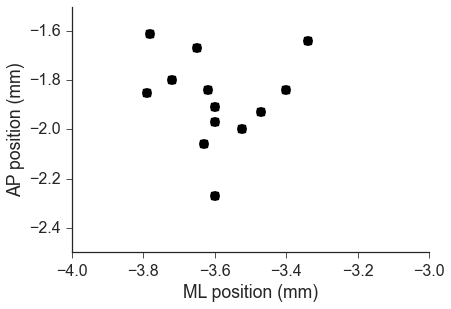

In [14]:
plt.plot(info.cordsML,info.cordsAP,'.', color='k', ms=20);
plt.ylim([-2.5, -1.5])
plt.xlim([-4.0, -3.0])
plt.xlabel('ML position (mm)')
plt.ylabel('AP position (mm)')
sns.despine()
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','Locations.eps'))

## Summarize units

#### Take only clean units

In [14]:
table = table[table.units.clean]

In [19]:
goodTuning = table.units.pVal < 0.05
table = table[goodTuning]

#### Summarize clean units

In [22]:
units = table.units.reset_index()
print len(units)
unitCount = units.groupby(['anmId']).count()['sourceId'].values
print np.mean(unitCount), np.std(unitCount), len(unitCount)

179
13.7692307692 6.22839460923 13


## Plot spike summary information

#### Plot example mean waveform

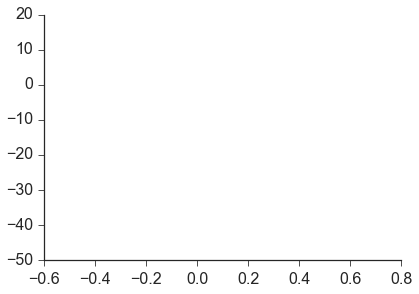

In [23]:
animals = ['Anm_0235585', 'Anm_0250492', 'Anm_0256043', 'Anm_0237723',
           'Anm_0237723', 'Anm_0250492', 'Anm_0250495']
sources = [9, 28, 0, 0, 27, 0, 8]
#session = [0,6,12,1,1,6,8]

for a, u in zip(animals, sources):
    x = table.waveforms.columns
    y = table.waveforms.loc[a,u].values
    time(x, y)
    plt.xlabel('Time (ms)');
    plt.ylabel('Voltage (uV)');
    if savefig:
        plt.savefig(os.path.join(path,'figuresEphys','Waveform%s_%s.eps' % (a, u)))
    plt.cla()
    

#### Plot distribution of spike widths

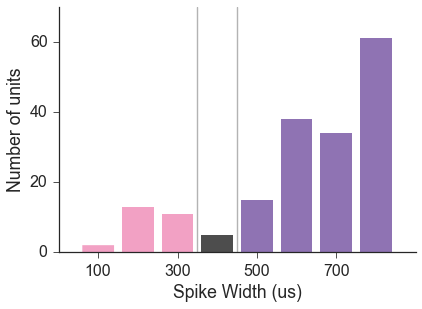

In [24]:
bins=range(50,950,100)
out = plt.hist(table.units.spkWidth, bins=bins, rwidth=0.8, color=[0.7,0.7,0.7], edgecolor='none');
plt.xlabel('Spike Width (us)')
plt.ylabel('Number of units')
col = [fs,fs,fs,frs,rs,rs,rs,rs]
for c, p in zip(col, out[2]):
    plt.setp(p, 'facecolor', c)
plt.plot([350, 350], [0, 70], color=[0.7,0.7,0.7], zorder=1)
plt.plot([450, 450], [0, 70], color=[0.7,0.7,0.7], zorder=1)
plt.ylim([0, 70])
plt.yticks(range(0,65,20))
plt.xticks(range(100,800,200))
sns.despine()
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','SpikeWidth.eps'))

#### Plot waveforms across cell types

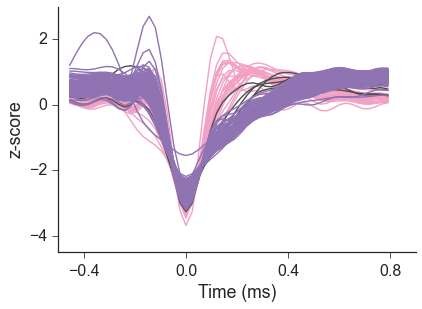

In [25]:
waves = table.waveforms[table.units.cellType == 'FastSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = fs);
waves = table.waveforms[table.units.cellType == 'IntermediateSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = frs);
waves = table.waveforms[table.units.cellType == 'RegularSpiker']
wavesNorm = normalize(waves.values)
for iSource in range(0,len(waves)):
    plt.plot(waves.columns.values,wavesNorm[iSource],color = rs);
sns.despine()
plt.xlabel('Time (ms)');
plt.ylabel('z-score');
plt.yticks(range(-4,3,2))
plt.ylim([-4.5, 3])
plt.xticks(np.linspace(-0.4,.8,4))
plt.xlim([-.5, .9])
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','Waveforms.eps'))

#### Plot example ISI

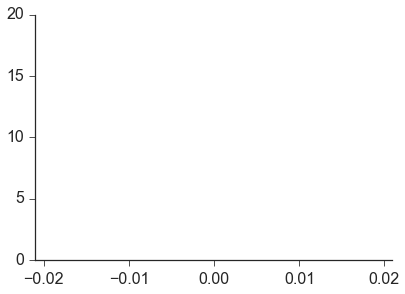

In [26]:
animals = ['Anm_0235585', 'Anm_0250492', 'Anm_0256043', 'Anm_0237723',
           'Anm_0237723', 'Anm_0250492', 'Anm_0250495', 'Anm_0235585',
           'Anm_0245918', 'Anm_0237723', 'Anm_0235585', 'Anm_0245918']
sources = [9, 28, 0, 0, 27, 0, 8, 12, 15, 2, 2, 2]
for a, u in zip(animals, sources):
    x = table.ISI.columns
    y = table.ISI.loc[a, u]
    plt.bar(-.0025, max(y), width=.005, linewidth=0, color=[.7, .7, .7]);
    plt.bar(x, y, width=.0002, linewidth=0, color='k');
    plt.xticks(np.linspace(-.02,.02,3))
    plt.xlim([-.021, 0.021])
    plt.xlabel('Time (s)');
    plt.ylabel('Spikes / bin');
    sns.despine()
    if savefig:
        plt.savefig(os.path.join(path,'figuresEphys','ISI%s_%s.eps' % (a, u)))
    plt.cla()

#### Plot waveform SNR vs False Alarm Rate

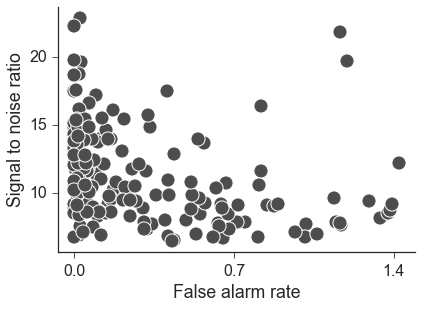

In [27]:
x = table.units.rateFA
y = table.units.waveformSNR
scatter(x, y, xlabel='False alarm rate', ylabel='Signal to noise ratio');
plt.xticks(np.linspace(0,1.4,3))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','SpikeQuality.eps'))

## Extract units for tuning analysis

In [28]:
table = table[table.units.cellType == 'RegularSpiker']
print len(table)

148


#FIGURE 3

## Plot tuning curves

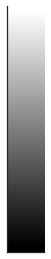

In [29]:
palBW = plt.get_cmap('gray')
colorbar(palBW)
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','ColorbarGray.eps'))

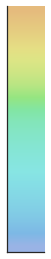

In [30]:
pal = colormap(0)
colorbar(pal)
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','Colorbar.eps'))

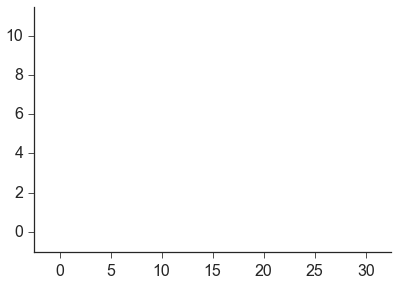

In [25]:
animals = ['Anm_0235585', 'Anm_0250492', 'Anm_0256043', 'Anm_0237723',
           'Anm_0237723']
sources = [9, 28, 0, 0, 27]

#animals = ['Anm_0237723', 'Anm_0237723', 'Anm_0237723', 'Anm_0237723']
#sources = [0, 7, 9, 12]

for a, u in zip(animals, sources):
    x = table.tuning.columns.values
    y = table.tuning.loc[a,u].values
    err = table.tuningErr.loc[a,u].values
    rng = tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
    if savefig:
        plt.savefig(os.path.join(path,'figuresEphys','Tuning%s_%s.eps' % (a, u)))
    plt.cla()

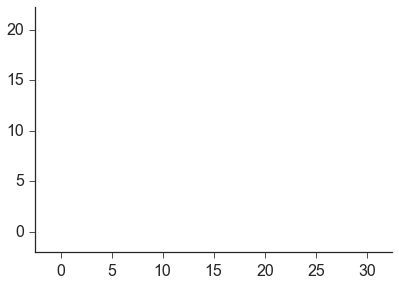

In [26]:
a = 'Anm_0250492'
u = 0

x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
rng = tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
plt.ylim([0 - rng*0.1, rng + rng*0.1]);
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','Tuning%s_%s.eps' % (a, u)))
plt.cla()
    
x = table.tuningIpsi.columns.values
y = table.tuningIpsi.loc[a,u].values
err = table.tuningIpsiErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
plt.ylim([0 - rng*0.1, rng + rng*0.1]);
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','TuningIpsi%s_%s.eps' % (a, u)))
plt.cla()
    
x = table.tuningClosed.columns.values[:11]
y = table.tuningClosed.loc[a,u].values[:11]
err = table.tuningClosedErr.loc[a,u].values[:11]
tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
plt.ylim([0 - rng*0.1, rng + rng*0.1]);

if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','TuningClosed%s_%s.eps' % (a, u)))
plt.cla()    

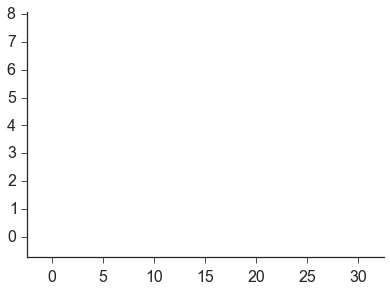

In [27]:
a = 'Anm_0250495'
u = 8

x = table.tuningIpsi.columns.values
y = table.tuningIpsi.loc[a,u].values
err = table.tuningIpsiErr.loc[a,u].values
rng = tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','TuningIpsi%s_%s.eps' % (a, u)))
plt.cla()

x = table.tuning.columns.values
y = table.tuning.loc[a,u].values
err = table.tuningErr.loc[a,u].values
tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
plt.ylim([0 - rng*0.1, rng + rng*0.1]);
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','Tuning%s_%s.eps' % (a, u)))
plt.cla()
    
x = table.tuningClosed.columns.values[:11]
y = table.tuningClosed.loc[a,u].values[:11]
err = table.tuningClosedErr.loc[a,u].values[:11]
tuning(x, y, err, smooth=smooth, ylabel='Firing rate (ips)');
plt.ylim([0 - rng*0.1, rng + rng*0.1]);

if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','TuningClosed%s_%s.eps' % (a, u)))
plt.cla()    

# Plot summary tuning curves

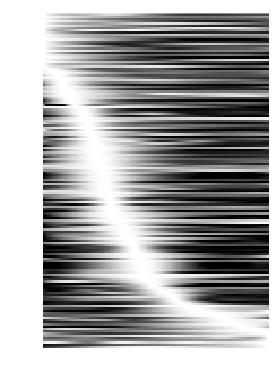

In [31]:
curves = table.sort([('tuningSummary','ArgMax')])
xy = [(curves.tuning.columns.values, y) for y in curves.tuning.values]
fits = smootharray(xy, smooth=smooth, res=100)
heatmap(fits, aspect=1)
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','Tuning%s_units.eps' % len(fits)))

## Plot summary data

#### Plot scatter of supression vs activation

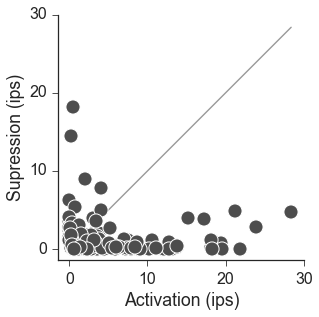

In [32]:
x = table.tuningSummary.Activation
y = table.tuningSummary.Supression
scatter(x, y, equal=True, xlabel='Activation (ips)', ylabel='Supression (ips)')
plt.yticks([0, 10, 20, 30])
plt.xticks([0, 10, 20, 30])
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','SupAct.eps'))

#### Plot histogram of modulation

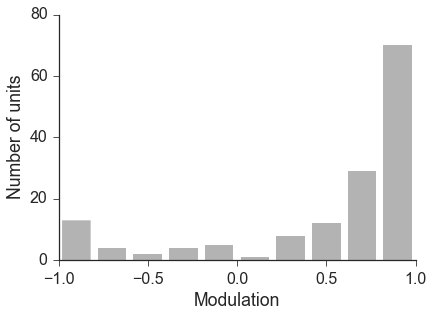

In [33]:
hist(table.tuningSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(np.linspace(0,80,5))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','SupActMod.eps'))

#### Plot scatter of wall out of reach activity across layer 4 distance

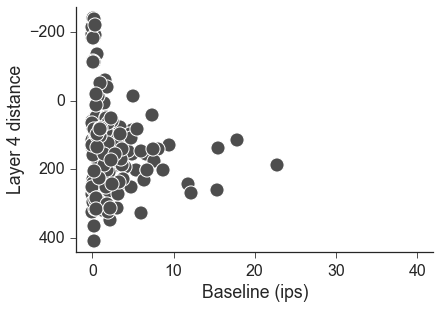

In [31]:
x = table.tuningSummary.Baseline
y = table.units.distLayer4
scatter(x, y, yinvert=True, xlabel='Baseline (ips)', ylabel='Layer 4 distance')
plt.xlim([-2, 42])
plt.yticks(np.linspace(-200,400,4))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','LaminaBaseline.eps'))

#### Plot scatter of peak wall distance activity across layer 4 distance

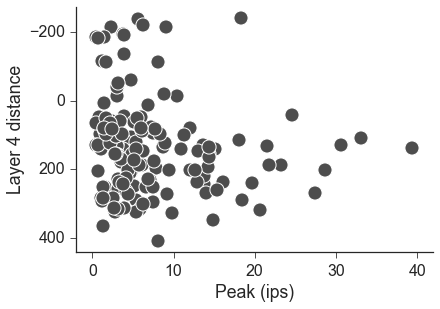

In [32]:
x = table.tuningSummary.Max
y = table.units.distLayer4
scatter(x, y, xlabel='Peak (ips)', ylabel='Layer 4 distance', yinvert=True)
plt.xlim([-2, 42])
plt.yticks(np.linspace(-200,400,4))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','LaminaPeak.eps'))

#### Plot scatter of wall modulation across layer 4 distance

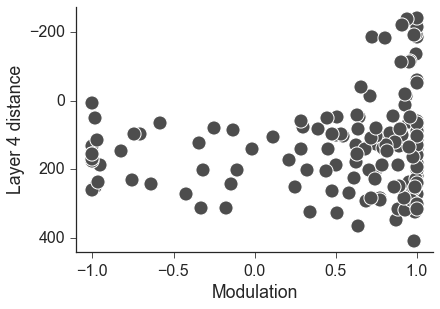

In [33]:
x = table.tuningSummary.Modulation
y = table.units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','LaminaModulation.eps'))

#Figure 4

## Plot profiles

In [35]:
animals = ['Anm_0235585', 'Anm_0245918', 'Anm_0237723', 'Anm_0235585']
sources = [12, 15, 2, 2]
#[0,2,1,0]
for a, u in zip(animals, sources):
    x1 = table.profile.columns.values[:500]
    x1 = x1 - x1[0]
    y1 = table.profile.loc[a, u].values[:500]
    x2 = table.profile.columns.values[500:]
    x2 = x2 - x2[0]
    y2 = table.profile.loc[a, u].values[500:]
    pairedtime(x1, y1, x2, y2);
    if savefig:
        plt.savefig(os.path.join(path,'figuresEphys','Profile%s_%s.eps' % (a, u)));
    plt.clf();

##Plot heatmap traces

#### Plot symmetric units

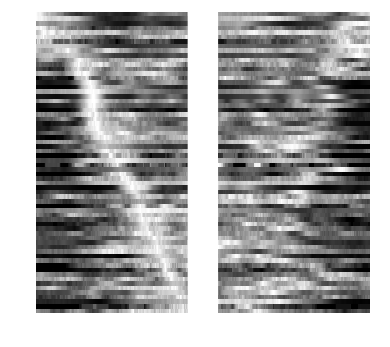

In [46]:
curves = table.sort([('profileSummary','ArgMaxTowards')])
curves = curves[curves.profileSummary.Modulation.abs()<=0.2]
vals1 = np.asarray([x[:500] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
vals2 = np.asarray([x[500:] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
pairedheatmap(vals1, vals2, aspect=15)
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','ProfileSym%s_units.eps' % len(vals1)))

#### Plot asymmetric units

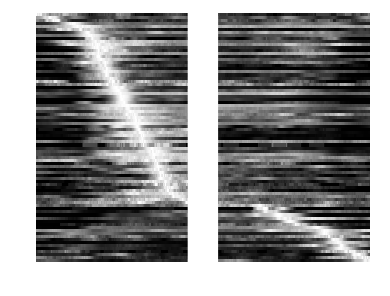

In [47]:
curves = table.sort([('profileSummary','ArgMax')])
curves = curves[curves.profileSummary.Modulation.abs()>0.2]
vals1 = np.asarray([x[:500] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
vals2 = np.asarray([x[500:] for x in curves.profile.values]) / curves.profileSummary.Max[:,None]
pairedheatmap(vals1, vals2, aspect=10)
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','ProfileAsym%s_units.eps' % len(vals1)))

##Plot summary data

#### Plot scatter of supression vs activation

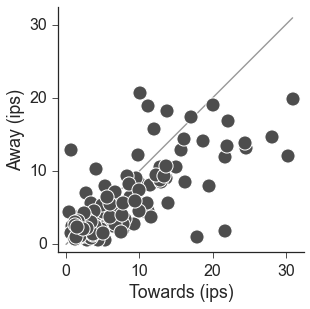

In [38]:
x = table.profileSummary.TowardsMod
y = table.profileSummary.AwayMod
scatter(x, y, equal=True, xlabel='Towards (ips)', ylabel='Away (ips)')
plt.yticks([0, 10, 20, 30])
plt.xticks([0, 10, 20, 30])
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','TowAway.eps'))

#### Plot histogram of modulation

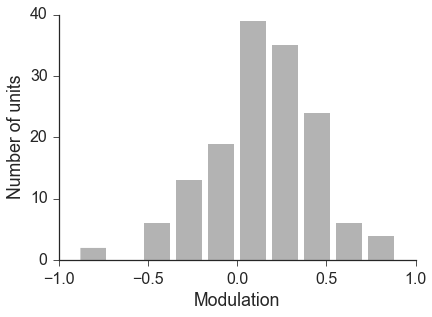

In [39]:
hist(table.profileSummary.Modulation, xlabel='Modulation', ylabel='Number of units')
plt.yticks(range(0,50,10))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','TowAwayMod.eps'))

#### Plot scatter of wall modulation across layer 4 distance

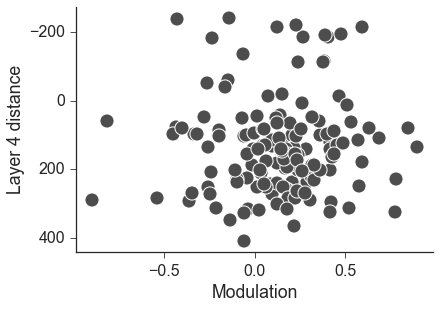

In [40]:
x = table.profileSummary.Modulation
y = table.units.distLayer4
scatter(x, y, xlabel='Modulation', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','LaminaProfileModulation.eps'))

#Figure 5

#### Ipsi vs contra summary

In [44]:
x = table[~table.units.pValIpsi.isnull()].tuningSummary.Range
y = table[~table.units.pValIpsi.isnull()].tuningIpsiSummary.Range
modLat = np.divide(x-y,x+y)

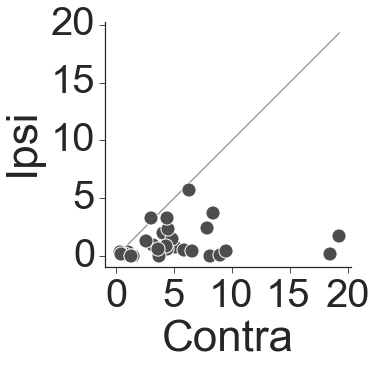

In [109]:
scatter(x, y, equal=True, xlabel='Contra', ylabel='Ipsi')
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','IpsiContra.eps'))

#### Histogram of ipsi vs contra modulation

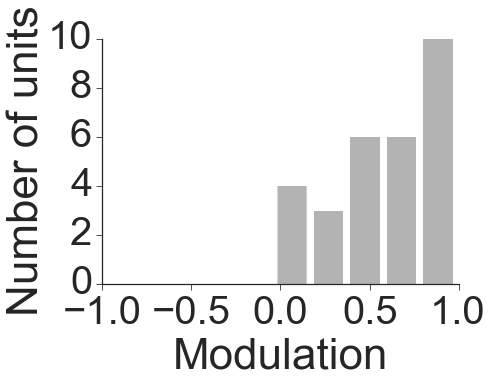

In [110]:
hist(modLat, bins=5, xlabel='Modulation', ylabel='Number of units')
plt.xlim([-1, 1]);
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','IpsiContraMod.eps'))

#Figure S1

#### Depth of units recorded

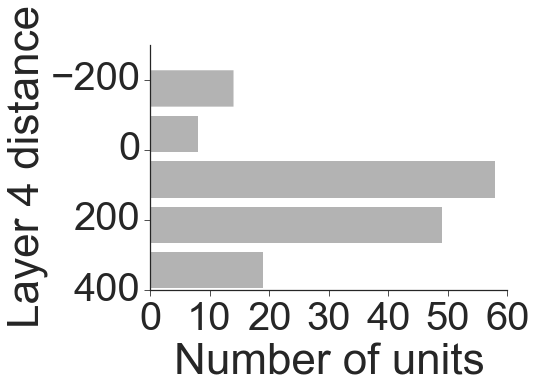

In [111]:
vals = table.units.distLayer4
hist(vals, bins=5, horizontal=True, xlabel='Number of units', ylabel='Layer 4 distance', yinvert=True)
plt.yticks(np.linspace(-200,400,4))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','LaminaNumber.eps'))

#Figure S2

#### Open loop vs closed loop summary

In [38]:
frac = table[~table.units.pValClosed.isnull()].tuningClosedNum.divide(table.tuningClosedNum.sum(axis=1),axis=0)<.02
vals = table[~table.units.pValClosed.isnull()].tuningClosed.values
vals = vals[:,:11]
frac = frac.values[:,:11]
vals[frac] = np.nan
x = np.nanmean(vals, axis=1)
vals = table[~table.units.pValClosed.isnull()].tuning.values
vals[frac] = np.nan
y = np.nanmean(vals, axis=1)
modLoop = np.divide(x-y,x+y)

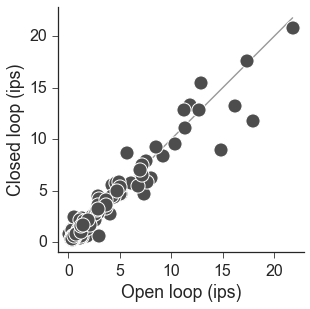

In [39]:
scatter(x, y, equal=True, xlabel='Open loop (ips)', ylabel='Closed loop (ips)')
#plt.tight_layout()
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','OpenClosed.eps'))

####Histogram of open vs closed loop modulation

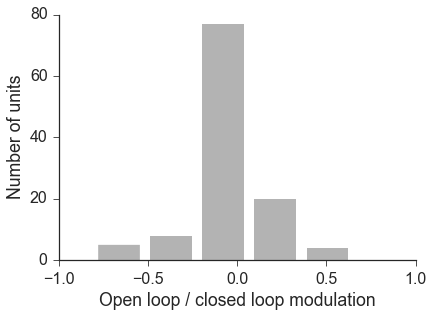

In [40]:
hist(modLoop, bins=5, xlabel='Open loop / closed loop modulation', ylabel='Number of units')
plt.xlim([-1, 1]);
plt.yticks(range(0,100,20))
if savefig:
    plt.savefig(os.path.join(path,'figuresEphys','OpenClosedMod.eps'))